In [11]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [12]:
BASE_DIR = './input/flickr8k'
WORKING_DIR = './working'

In [7]:

model = VGG16()

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [8]:

features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # Load the image from file
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # Convert image pixels to numpy array
    image = img_to_array(image)
    # Reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess image for VGG
    image = preprocess_input(image)
    # Extract features
    feature = model.predict(image, verbose=0)
    # Get image ID
    image_id = img_name.split('.')[0]
    # Store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

100%|██████████| 8091/8091 [1:23:30<00:00,  1.61it/s]


In [9]:

pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [34]:

with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [35]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [17]:

mapping = {}

for line in tqdm(captions_doc.split('\n')):
    
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
   
    image_id = image_id.split('.')[0]
    
    caption = " ".join(caption)
    
    if image_id not in mapping:
        mapping[image_id] = []
    
    mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 194091.59it/s]


In [18]:
len(mapping)

8091

In [19]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            
            caption = captions[i]
            
            caption = caption.lower()
             
            caption = caption.replace('[^A-Za-z]', '')
           
            caption = caption.replace('\s+', ' ')
            
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [20]:

mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [21]:

clean(mapping)

In [22]:

mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [23]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [19]:
len(all_captions)

40455

In [20]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [24]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [22]:
vocab_size

8485

In [25]:

max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [26]:
image_ids = list(mapping.keys())
# Split the data into training, validation, and testing sets
train_val, test = train_test_split(image_ids, test_size=0.1, random_state=42)
train, val = train_test_split(train_val, test_size=0.056, random_state=42)  # 0.056 = 0.05 / (1 - 0.1)


print("Training set length:", len(train))
print("Validation set length:", len(val))
print("Testing set length:", len(test))

Training set length: 6873
Validation set length: 408
Testing set length: 810


In [27]:

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            
            for caption in captions:
                
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # Split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # Encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [28]:
# Encoder model
# Image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# Sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
# Train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size
validation_steps = len(val) // batch_size

history = model.fit(
    data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    epochs=epochs,
    steps_per_epoch=steps,
    validation_data=data_generator(val, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/20
214/214 [==============================] - 436s 2s/step - loss: 5.2366 - val_loss: 4.4359
Epoch 2/20
214/214 [==============================] - 444s 2s/step - loss: 4.0371 - val_loss: 3.9964
Epoch 3/20
214/214 [==============================] - 471s 2s/step - loss: 3.5952 - val_loss: 3.9012
Epoch 4/20
214/214 [==============================] - 436s 2s/step - loss: 3.3229 - val_loss: 3.9044
Epoch 5/20
214/214 [==============================] - 420s 2s/step - loss: 3.1218 - val_loss: 3.9422
Epoch 6/20
214/214 [==============================] - 433s 2s/step - loss: 2.9659 - val_loss: 3.9629
Epoch 7/20
214/214 [==============================] - 476s 2s/step - loss: 2.8459 - val_loss: 3.9980
Epoch 8/20
214/214 [==============================] - 447s 2s/step - loss: 2.7541 - val_loss: 4.0333
Epoch 9/20
214/214 [==============================] - 368s 2s/step - loss: 2.6721 - val_loss: 4.1259
Epoch 10/20
214/214 [==============================] - 412s 2s/step - loss: 2.6042 - val_lo

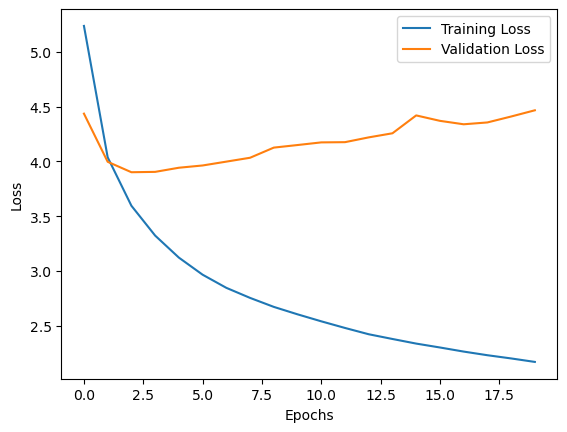

In [28]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# Save the model
model.save(os.path.join(WORKING_DIR, 'image_captioning_model.h5'))

In [29]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [30]:
# Generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # Add start tag for generation process
    in_text = 'startseq'
    # Iterate over the max length of sequence
    for i in range(max_length):
        # Encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # Predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # Get index with high probability
        yhat = np.argmax(yhat)
        # Convert index to word
        word = idx_to_word(yhat, tokenizer)
        # Stop if word not found
        if word is None:
            break
        # Append word as input for generating next word
        in_text += " " + word
        # Stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [36]:
from nltk.translate.bleu_score import corpus_bleu

# Validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # Get actual caption
    captions = mapping[key]
    # Predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # Split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # Append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# Calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

100%|██████████| 810/810 [41:26<00:00,  3.07s/it]
c:\Users\prana\anaconda3\envs\python37\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\prana\anaconda3\envs\python37\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\prana\anaconda3\envs\python37\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lo

BLEU-1: 0.027812
BLEU-2: 0.000000


In [37]:
from PIL import Image
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # Predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel cartwheel


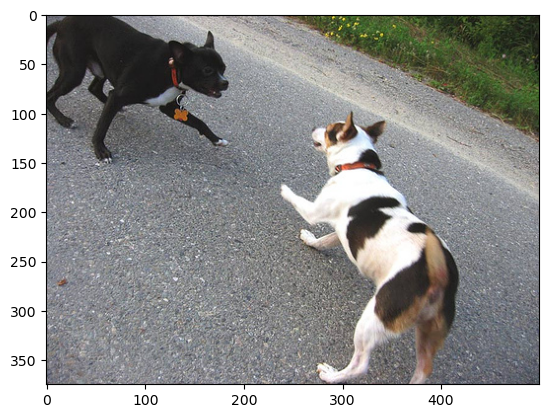

In [38]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq woman crouches near three dogs in field endseq
startseq three dogs are playing on grassy hill with blue sky endseq
startseq three dogs are standing in the grass and person is sitting next to them endseq
startseq three dogs on grassy hill endseq
startseq three dogs stand in grassy field while person kneels nearby endseq
--------------------Predicted--------------------
startseq two dogs are playing in grassy grassy hill endseq


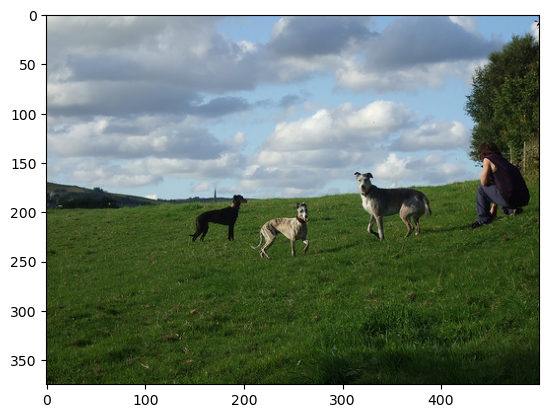

In [35]:
generate_caption("1032122270_ea6f0beedb.jpg")

In [39]:
vgg_model = VGG16()
# Restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [40]:
image_path = 'kaggle/input/flickr8k/Images/1233.jpg'
# Load image
image = load_img(image_path, target_size=(224, 224))
# Convert image pixels to numpy array
image = img_to_array(image)
# Reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# Preprocess image for VGG
image = preprocess_input(image)
# Extract features
feature = vgg_model.predict(image, verbose=0)
# Predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase phrase'

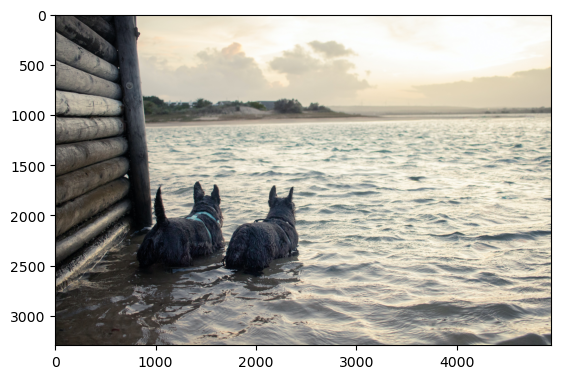

In [51]:
IMAGE = Image.open(image_path)
plt.imshow(IMAGE)